In [3]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import ROOT

In [2]:
single = '/eos/user/b/bbapi/CMSSW_13_3_1_patch1/src/NanoAODProduction/NanoAODv13/test/M20-RunIISummer20UL18NanoAODv2/B7D21F37-159B-4F42-B1A8-97F4732749B9.root'

In [3]:
factory = NanoEventsFactory.from_root(
    f"{single}:Events",
    schemaclass=NanoAODSchema,
)
events = factory.events()

events = ak.materialize(events)

In [4]:
events.Jet.fields

['jetId',
 'nConstituents',
 'nElectrons',
 'nMuons',
 'nSVs',
 'puId',
 'electronIdx1',
 'electronIdx2',
 'muonIdx1',
 'muonIdx2',
 'svIdx1',
 'svIdx2',
 'hfadjacentEtaStripsSize',
 'hfcentralEtaStripSize',
 'PNetRegPtRawCorr',
 'PNetRegPtRawCorrNeutrino',
 'PNetRegPtRawRes',
 'area',
 'btagCSVV2',
 'btagDeepB',
 'btagDeepCvB',
 'btagDeepCvL',
 'btagDeepFlavB',
 'btagDeepFlavCvB',
 'btagDeepFlavCvL',
 'btagDeepFlavQG',
 'btagPNetB',
 'btagPNetCvB',
 'btagPNetCvL',
 'btagPNetQvG',
 'btagPNetTauVJet',
 'btagRobustParTAK4B',
 'btagRobustParTAK4CvB',
 'btagRobustParTAK4CvL',
 'btagRobustParTAK4QG',
 'chEmEF',
 'chFPV0EF',
 'chHEF',
 'eta',
 'hfsigmaEtaEta',
 'hfsigmaPhiPhi',
 'mass',
 'muEF',
 'muonSubtrFactor',
 'neEmEF',
 'neHEF',
 'phi',
 'pt',
 'puIdDisc',
 'qgl',
 'rawFactor',
 'bRegCorr',
 'bRegRes',
 'cRegCorr',
 'cRegRes',
 'hadronFlavour',
 'genJetIdx',
 'partonFlavour',
 'electronIdx1G',
 'electronIdx2G',
 'genJetIdxG',
 'muonIdx1G',
 'muonIdx2G',
 'muonIdxG',
 'electronIdxG']

In [144]:
events.Jet.genJetIdxG

<Array [[0, 1, -1, -1, -1], ..., [337426, ...]] type='66000 * var * int64[p...'>

In [5]:
def delta_r_manual(obj1, obj2):
    deta = obj1.eta[:, None] - obj2.eta
    dphi = np.abs(obj1.phi[:, None] - obj2.phi)
    dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return np.sqrt(deta**2 + dphi**2)

In [143]:
tagger = "btagCSVV2" 

threshold = 0.23

gen = events.GenPart

gen_b = gen[(abs(gen.pdgId) == 5) & (gen.status == 23)]

# 2) Require valid mother and mother pdgId == 35 (A)
mother_idx  = gen_b.genPartIdxMother
valid_mom   = mother_idx >= 0
idx_safe    = ak.where(valid_mom, mother_idx, 0)          # avoid negative indexing
mom_pdgid   = gen[idx_safe].pdgId
from_a_mask = valid_mom & (abs(mom_pdgid) == 35)

# Keep only b’s from A (still preserves event count; events with no matches → empty lists)
gen_b_from_a = gen_b[from_a_mask]

gen_b_from_a = gen_b_from_a[ak.argsort(gen_b_from_a.pt, axis=1, ascending=False)]

# leading and subleading jets
lead_b = ak.firsts(gen_b_from_a)      # first jet
sublead_b = gen_b_from_a[:, 1] 

jets = events.Jet

tagged_jets = jets[jets[tagger] > threshold]

# pad each event to have at least 2 entries
jets_padded_before = ak.pad_none((jets), 2)  

dR_before_lead = delta_r_manual(lead_b, jets_padded_before)
dR_before_sublead = delta_r_manual(sublead_b, jets_padded_before)

dR_before = np.minimum(dR_before_lead, dR_before_sublead)

success_rate_before = ak.sum(dR_before < 0.4) / ak.sum(ak.num(dR_before))

count_total_valid_before = ak.sum(ak.num(dR_before))   # counts all non-None entries

print(f"Success rate before: {success_rate_before:.3f}")

empty_jets = ak.Array([[]] * len(events))

at_least_two_jets = ak.num(tagged_jets) >= 2

event_mask = at_least_two_jets

filtered_jets = ak.where(event_mask, tagged_jets, empty_jets)

# pad each event to have at least 2 entries
jets_padded = ak.pad_none(tagged_jets, 2)  

dR_after_lead = delta_r_manual(lead_b, jets_padded)
dR_after_sublead = delta_r_manual(sublead_b, jets_padded)

dR_after = np.minimum(dR_after_lead, dR_after_sublead)

dR_clean = ak.drop_none(dR_after)

# Now compute the stats safely
count_below_0p4 = ak.sum(dR_clean < 0.4)
count_total_valid = ak.sum(ak.num(dR_clean))   # counts all non-None entries

success_rate = count_below_0p4 / count_total_valid

efficiency = count_total_valid / count_total_valid_before

# eff_after = ak.sum(dR_after < 0.4) / ak.sum(ak.num(dR_after))
print(f"Success rate after b-tagging by {tagger}: {success_rate:.3f}")
print(f"Efficiency: {efficiency:.3f}")



Success rate before: 0.182
Success rate after b-tagging by btagCSVV2: 0.317
Efficiency: 0.488


In [ ]:
def delta_r(eta1, phi1, eta2, phi2):
    dphi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    deta = eta1 - eta2
    return np.sqrt(deta**2 + dphi**2)

In [7]:
tagger = "btagCSVV2" 

threshold = 0.23

gen = events.GenPart

gen_b = gen[(abs(gen.pdgId) == 5) & (gen.status == 23)]

# 2) Require valid mother and mother pdgId == 35 (A)
mother_idx  = gen_b.genPartIdxMother
valid_mom   = mother_idx >= 0
idx_safe    = ak.where(valid_mom, mother_idx, 0)          # avoid negative indexing
mom_pdgid   = gen[idx_safe].pdgId
from_a_mask = valid_mom & (abs(mom_pdgid) == 35)

# Keep only b’s from A (still preserves event count; events with no matches → empty lists)
gen_b_from_a = gen_b[from_a_mask]

gen_b_from_a = gen_b_from_a[ak.argsort(gen_b_from_a.pt, axis=1, ascending=False)]

# leading and subleading jets
lead_b = ak.firsts(gen_b_from_a)      # first jet
sublead_b = gen_b_from_a[:, 1] 

jets = events.Jet

tagged_jets = jets[jets[tagger] > threshold]

# pad each event to have at least 2 entries
jets_padded_before = ak.pad_none((jets), 2)  

# Sort photons by pt
sorted_jets = gen_b_from_a[ak.argsort(gen_b_from_a.pt, axis=1, ascending=False)]

# Pad to at least 2 photons per event (None if missing)
sorted_jets_padded = ak.pad_none(sorted_jets, 2, axis=1, clip=True)


lead_eta_b_gen = ak.fill_none(sorted_jets_padded.eta[:, 0], np.nan)
sublead_eta_b_gen = ak.fill_none(sorted_jets_padded.eta[:, 1], np.nan)

lead_phi_b_gen = ak.fill_none(sorted_jets_padded.phi[:, 0], np.nan)
sublead_phi_b_gen = ak.fill_none(sorted_jets_padded.phi[:, 1], np.nan)

dR_before_lead    = delta_r(lead_eta_b_gen, lead_phi_b_gen, jets.eta, jets.phi)
dR_before_sublead = delta_r(sublead_eta_b_gen, sublead_phi_b_gen, jets.eta, jets.phi)

dR_before_lead_min = ak.min(dR_before_lead, axis =1)
dR_before_sublead_min = ak.min(dR_before_sublead, axis =1)

dR_before = np.minimum(dR_before_lead, dR_before_sublead)

# --- select closest reco photon per gen photon ---
min_idx_jet1 = ak.argmin(dR_before_lead, axis=1, keepdims=False)
min_idx_jet2 = ak.argmin(dR_before_sublead, axis=1, keepdims=False)

min_dr_jet1 = ak.min(dR_before_lead, axis=1, initial=np.inf)
min_dr_jet2 = ak.min(dR_before_sublead, axis=1, initial=np.inf)

# mask away if ΔR >= 0.1
min_idx_jet1 = ak.mask(min_idx_jet1, min_dr_jet1 < 0.4)
min_idx_jet2 = ak.mask(min_idx_jet2, min_dr_jet2 < 0.4)

# --- conflict resolution (if needed, e.g., same reco photon matched to both gen photons) ---
both_valid_jet = ~ak.is_none(min_idx_jet1) & ~ak.is_none(min_idx_jet2)
indices_equal_jet = ak.where(both_valid_jet, min_idx_jet1 == min_idx_jet2, False)
conflict_jet = both_valid_jet & indices_equal_jet
valid_dr_jet = ~ak.is_none(dR_before_lead) & ~ak.is_none(dR_before_sublead)
compare_mask_jet = conflict_jet & valid_dr_jet

keep_jet1 = ak.where(compare_mask_jet, dR_before_lead <= dR_before_sublead, True)
keep_jet2 = ak.where(compare_mask_jet, dR_before_sublead < dR_before_lead, True)

min_idx_jet1 = ak.mask(min_idx_jet1, keep_jet1)
min_idx_jet2 = ak.mask(min_idx_jet2, keep_jet2)

jet_idx = ak.local_index(jets)

mask_idx_jet1 = jet_idx == min_idx_jet1
mask_idx_jet2 = jet_idx == min_idx_jet2

# --- now select reco photons ---
selected_jet_1 = ak.firsts(jets[mask_idx_jet1])
selected_jet_2 = ak.firsts(jets[mask_idx_jet2])

# success_rate_before = ak.sum(dR_before < 0.4) / ak.sum(ak.num(dR_before))

# count_total_valid_before = ak.sum(ak.num(dR_before))   # counts all non-None entries

# print(f"Success rate before: {success_rate_before:.3f}")

# empty_jets = ak.Array([[]] * len(events))

# # at_least_two_jets = ak.num(tagged_jets) >= 2

# # event_mask = at_least_two_jets

# # filtered_jets = ak.where(event_mask, tagged_jets, empty_jets)

# # pad each event to have at least 2 entries
# jets_padded = ak.pad_none(tagged_jets, 2)  

# dR_after_lead = delta_r_manual(lead_b, jets_padded)
# dR_after_sublead = delta_r_manual(sublead_b, jets_padded)

# dR_after = np.minimum(dR_after_lead, dR_after_sublead)

# dR_clean = ak.drop_none(dR_after)

# # Now compute the stats safely
# count_below_0p4 = ak.sum(dR_clean < 0.4)
# count_total_valid = ak.sum(ak.num(dR_clean))   # counts all non-None entries

# success_rate = count_below_0p4 / count_total_valid

# efficiency = count_total_valid / count_total_valid_before

# # eff_after = ak.sum(dR_after < 0.4) / ak.sum(ak.num(dR_after))
# print(f"Success rate after b-tagging by {tagger}: {success_rate:.3f}")
# print(f"Efficiency: {efficiency:.3f}")

ValueError: cannot broadcast records in equal

In [169]:
min_idx_jet1

<Array [[0, None, None, 0, 0], 2, ..., 10] type='66000 * union[option[var *...'>

In [170]:
gen = events.GenPart
higgs_mask = (gen.pdgId == 25) & (gen.status == 62)
higgs = gen[higgs_mask]
W_mask = (abs(gen.pdgId) == 24) & (gen.status == 62)
W = gen[W_mask]

higgs_pt = ak.flatten(higgs.pt)
higgs_eta = ak.flatten(higgs.eta)
higgs_phi = ak.flatten(higgs.phi)

W_pt = ak.flatten(W.pt)
W_eta = ak.flatten(W.eta)
W_phi = ak.flatten(W.phi)

is_A = (abs(gen.pdgId) == 35)

A = gen[is_A]

A_pt = A.pt
A_eta = A.eta
A_phi = A.phi

sorted_As = A[ak.argsort(A_pt, axis=1, ascending=False)]

leading_A_pt = sorted_As.pt[:,0]
subleading_A_pt = sorted_As.pt[:,1]
leading_A_eta = sorted_As.eta[:,0]
subleading_A_eta = sorted_As.eta[:,1]
leading_A_phi = sorted_As.phi[:,0]
subleading_A_phi = sorted_As.phi[:,1]

photons = gen[(gen.pdgId == 22) & (gen.status == 1)]
mother_idx = photons.genPartIdxMother
from_a_mask = gen[mother_idx].pdgId == 35
photons_from_a = photons[from_a_mask]

# Pad to at least 2 photons per event (None if not available)
photons_from_a_padded = ak.pad_none(photons_from_a, 2, axis=1, clip=True)

# Extract pt, eta, phi
pho_from_a_pt  = photons_from_a_padded.pt
pho_from_a_eta = photons_from_a_padded.eta
pho_from_a_phi = photons_from_a_padded.phi

# Split leading and subleading, replacing None with NaN
pho_from_a_pt_1  = ak.fill_none(pho_from_a_pt[:, 0], np.nan)
pho_from_a_pt_2  = ak.fill_none(pho_from_a_pt[:, 1], np.nan)
pho_from_a_eta_1 = ak.fill_none(pho_from_a_eta[:, 0], np.nan)
pho_from_a_eta_2 = ak.fill_none(pho_from_a_eta[:, 1], np.nan)
pho_from_a_phi_1 = ak.fill_none(pho_from_a_phi[:, 0], np.nan)
pho_from_a_phi_2 = ak.fill_none(pho_from_a_phi[:, 1], np.nan)

# Sort photons by pt
sorted_photons = photons_from_a[ak.argsort(photons_from_a.pt, axis=1, ascending=False)]

# Pad to at least 2 photons per event (None if missing)
sorted_photons_padded = ak.pad_none(sorted_photons, 2, axis=1, clip=True)

# Extract leading and subleading with NaN fill
lead_pt_pho_gen  = ak.fill_none(sorted_photons_padded.pt[:, 0],  np.nan)
sublead_pt_pho_gen  = ak.fill_none(sorted_photons_padded.pt[:, 1],  np.nan)

lead_eta_pho_gen = ak.fill_none(sorted_photons_padded.eta[:, 0], np.nan)
sublead_eta_pho_gen = ak.fill_none(sorted_photons_padded.eta[:, 1], np.nan)

lead_phi_pho_gen = ak.fill_none(sorted_photons_padded.phi[:, 0], np.nan)
sublead_phi_pho_gen = ak.fill_none(sorted_photons_padded.phi[:, 1], np.nan)

bquarks = gen[abs(gen.pdgId) == 5]
mother_idx = bquarks.genPartIdxMother
from_a_mask = gen[mother_idx].pdgId == 35
bquarks_from_a = bquarks[from_a_mask]

bquark_from_a_pt = bquarks_from_a.pt
bquark_from_a_eta = bquarks_from_a.eta
bquark_from_a_phi = bquarks_from_a.phi

bquark_from_a_pt_1 = bquark_from_a_pt[:, 0]
bquark_from_a_pt_2 = bquark_from_a_pt[:, 1]
bquark_from_a_eta_1 = bquark_from_a_eta[:, 0]
bquark_from_a_eta_2 = bquark_from_a_eta[:, 1]
bquark_from_a_phi_1 = bquark_from_a_phi[:, 0]
bquark_from_a_phi_2 = bquark_from_a_phi[:, 1]

sorted_bquarks = bquarks_from_a[ak.argsort(bquarks_from_a.pt, axis=1, ascending=False)]
lead_pt_bquark_gen = sorted_bquarks.pt[:, 0]
sublead_pt_bquark_gen = sorted_bquarks.pt[:, 1]
lead_eta_bquark_gen = sorted_bquarks.eta[:, 0]
sublead_eta_bquark_gen = sorted_bquarks.eta[:, 1]
lead_phi_bquark_gen = sorted_bquarks.phi[:, 0]
sublead_phi_bquark_gen = sorted_bquarks.phi[:, 1]

# Don't drop events up front!
reco_photons = events.Photon  # keep all events

Reco_pho_pt = ak.flatten(reco_photons.pt)
Reco_pho_eta = ak.flatten(reco_photons.eta)
Reco_pho_phi = ak.flatten(reco_photons.phi)

# Sort photons by pt
sorted_reco_photons = reco_photons[ak.argsort(reco_photons.pt, axis=1, ascending=False)]

# Pad so every event has at least 2 photons (None if missing)
sorted_reco_padded = ak.pad_none(sorted_reco_photons, 2, axis=1, clip=True)

# Fill missing with NaN
Reco_lead_pho_pt  = ak.fill_none(sorted_reco_padded.pt[:, 0],  np.nan)
Reco_sublead_pho_pt  = ak.fill_none(sorted_reco_padded.pt[:, 1],  np.nan)

Reco_lead_pho_eta = ak.fill_none(sorted_reco_padded.eta[:, 0], np.nan)
Reco_sublead_pho_eta = ak.fill_none(sorted_reco_padded.eta[:, 1], np.nan)

Reco_lead_pho_phi = ak.fill_none(sorted_reco_padded.phi[:, 0], np.nan)
Reco_sublead_pho_phi = ak.fill_none(sorted_reco_padded.phi[:, 1], np.nan)

def delta_r(eta1, phi1, eta2, phi2):
    dphi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    deta = eta1 - eta2
    return np.sqrt(deta**2 + dphi**2)

# ---------------- ΔR between gen lead/sublead photons and all reco photons ----------------
dr_pho_lead    = delta_r(lead_eta_pho_gen, lead_phi_pho_gen, reco_photons.eta, reco_photons.phi)
dr_pho_sublead = delta_r(sublead_eta_pho_gen, sublead_phi_pho_gen, reco_photons.eta, reco_photons.phi)

# --- select closest reco photon per gen photon ---
min_idx_pho1 = ak.argmin(dr_pho_lead, axis=1, keepdims=False)
min_idx_pho2 = ak.argmin(dr_pho_sublead, axis=1, keepdims=False)

min_dr_pho1 = ak.min(dr_pho_lead, axis=1, initial=np.inf)
min_dr_pho2 = ak.min(dr_pho_sublead, axis=1, initial=np.inf)

# mask away if ΔR >= 0.1
min_idx_pho1 = ak.mask(min_idx_pho1, min_dr_pho1 < 0.1)
min_idx_pho2 = ak.mask(min_idx_pho2, min_dr_pho2 < 0.1)

# --- conflict resolution (if needed, e.g., same reco photon matched to both gen photons) ---
both_valid_pho = ~ak.is_none(min_idx_pho1) & ~ak.is_none(min_idx_pho2)
indices_equal_pho = ak.where(both_valid_pho, min_idx_pho1 == min_idx_pho2, False)
conflict_pho = both_valid_pho & indices_equal_pho
valid_dr_pho = ~ak.is_none(dr_pho_lead) & ~ak.is_none(dr_pho_sublead)
compare_mask_pho = conflict_pho & valid_dr_pho

keep_pho1 = ak.where(compare_mask_pho, dr_pho_lead <= dr_pho_sublead, True)
keep_pho2 = ak.where(compare_mask_pho, dr_pho_sublead < dr_pho_lead, True)

min_idx_pho1 = ak.mask(min_idx_pho1, keep_pho1)
min_idx_pho2 = ak.mask(min_idx_pho2, keep_pho2)

photon_idx = ak.local_index(reco_photons)

mask_idx_pho1 = photon_idx == min_idx_pho1
mask_idx_pho2 = photon_idx == min_idx_pho2

# --- now select reco photons ---
selected_photon_1 = ak.firsts(reco_photons[mask_idx_pho1])
selected_photon_2 = ak.firsts(reco_photons[mask_idx_pho2])

In [165]:
dR_before_lead_min

<Array [0.0787, 0.022, 0.088, ..., 0.071, 0.0442] type='66000 * ?float32'>

In [120]:
jets.pt

<Array [[80.6, 74.8, ..., 18.6, 16.4], ...] type='66000 * var * float32[par...'>

In [121]:
at_least_two_jets

<Array [True, True, False, False, ..., True, True, True] type='66000 * bool'>

In [125]:
tagged_jets.pt

<Array [[80.6, 41.6, 16.4], ..., [70.2, ...]] type='66000 * var * float32[p...'>

In [128]:
dR_valid_events[:3]

<Array [[0.0787, 4.33, 1.89], ..., [...]] type='3 * var * ?float32[paramete...'>

In [130]:
import awkward as ak

dR_test = ak.Array([
    [0.0787, 4.33, 1.89],
    [2.47, 0.022, 2.56],
    [0.088, None]
])

# Drop None values explicitly first
dR_clean = ak.drop_none(dR_test)

# Now compute the stats safely
count_below_0p4 = ak.sum(dR_clean < 0.4)
count_total_valid = ak.sum(ak.num(dR_clean))   # counts all non-None entries

fraction_below_0p4 = count_below_0p4 / count_total_valid

print(f"Entries < 0.4 (excluding None): {int(count_below_0p4)} / {int(count_total_valid)} "
      f"= {float(fraction_below_0p4):.3f}")


Entries < 0.4 (excluding None): 3 / 7 = 0.429


In [131]:
dR_clean

<Array [[0.0787, 4.33, 1.89], [...], [0.088]] type='3 * var * float64'>

In [113]:
dR_after[200:240]

<Array [[None, None], ..., [0.0315, ..., 1.95]] type='40 * var * ?float32[p...'>

In [75]:
ak.sum(mask_valid[:10])

10

In [107]:
jets_padded[:10].pt

<Array [[80.6, 41.6, 16.4], ..., [36.4, ...]] type='10 * var * ?float32[par...'>

In [55]:
dR_before[:2]

<Array [[0.0787, 2.07, ..., 3.2, 1.89], ...] type='2 * var * ?float32[param...'>

In [ ]:
ak.sum(dR_valid < 0.4)

In [15]:
ak.all(ak.num(gen_b_from_a.pt)==2)

True

In [18]:
dR_before_lead

<Array [[0.0787, 2.07, ..., 3.2, 1.89], ...] type='66000 * var * ?float32[p...'>

In [23]:
dR_before_sublead

<Array [[0.344, 2.07, ..., 3.53, 2.03], ...] type='66000 * var * ?float32[p...'>

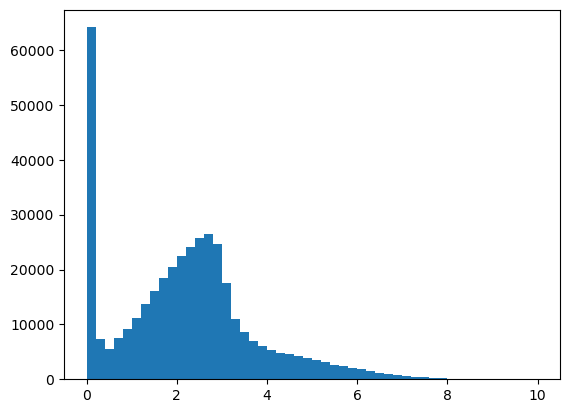

In [32]:
plt.hist(ak.flatten(dR_before), range = (0,10), bins = 50);

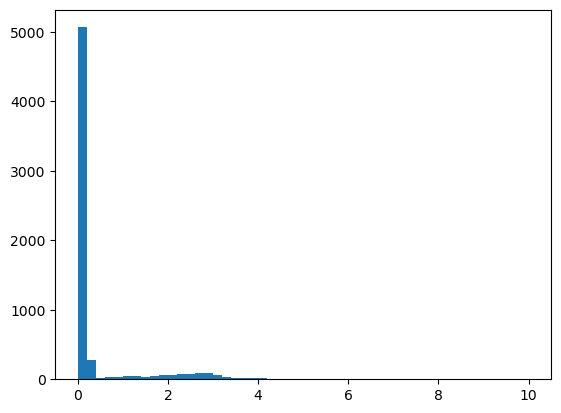

In [92]:
plt.hist(ak.flatten(dR_after), range = (0,10), bins = 50);

In [153]:
events.Jet.pt

<Array [[80.6, 74.8, ..., 18.6, 16.4], ...] type='66000 * var * float32[par...'>

In [145]:
good_jets = (
    (events.Jet.pt > 20)
    & (np.abs(events.Jet.eta) < 2.4)
    # & (events.Jet.btagDeepFlavB > wp_medium)
    & (events.Jet.btagCSVV2 > 0.273)
)

In [148]:
good_jets = events.Jet[good_jets].pt

In [151]:
at_least_two_jets = ak.num(good_jets) >= 2
events.Jet[at_least_two_jets].pt

<Array [[225, 75.1, ..., 28.7, 25.6], ...] type='33807 * var * float32[para...'>

In [120]:
tagger = "btagCSVV2" 

threshold = 0.23

gen = events.GenPart

gen_b = gen[(abs(gen.pdgId) == 5) & (gen.status == 23)]

# 2) Require valid mother and mother pdgId == 35 (A)
mother_idx  = gen_b.genPartIdxMother
valid_mom   = mother_idx >= 0
idx_safe    = ak.where(valid_mom, mother_idx, 0)          # avoid negative indexing
mom_pdgid   = gen[idx_safe].pdgId
from_a_mask = valid_mom & (abs(mom_pdgid) == 35)

# Keep only b’s from A (still preserves event count; events with no matches → empty lists)
gen_b_from_a = gen_b[from_a_mask]

gen_b_from_a = gen_b_from_a[ak.argsort(gen_b_from_a.pt, axis=1, ascending=False)]

# leading and subleading jets
lead_b = ak.firsts(gen_b_from_a)      # first jet
sublead_b = gen_b_from_a[:, 1] 

jets = events.Jet

# tagged_jets = jets[jets[tagger] > threshold]  

dR_after_lead = delta_r_manual(lead_b, jets)
dR_after_sublead = delta_r_manual(sublead_b, jets)



In [56]:
jets.pt

<Array [[80.6, 74.8, ..., 18.6, 16.4], ...] type='66000 * var * float32[par...'>

In [104]:
tagged_jets[10:20].pt

<Array [[225, 28.7], ..., [66.7, ..., 15.3]] type='10 * var * float32[param...'>

In [121]:
dR_after_lead[10:20]

<Array [[0.162, 2.88, ..., 1.93, 1.11], ...] type='10 * var * ?float32[para...'>

In [122]:
dR_after_sublead[10:20]

<Array [[0.183, 2.67, ..., 2, 0.925], ...] type='10 * var * float32[paramet...'>

In [28]:
lead_min_idx = ak.argmin(dR_after_lead, axis=1, keepdims=False)
sublead_min_idx = ak.argmin(dR_after_sublead, axis=1, keepdims=False)

In [73]:
lead_min_idx

<Array [0, 1, 0, 0, 0, 0, 0, 0, ..., 0, 1, 2, 0, 1, 0, 3] type='66000 * ?int64'>

In [72]:
sublead_min_idx

<Array [0, 1, 0, 0, 0, 2, 0, 0, ..., 0, 2, 2, 0, 1, 0, 3] type='66000 * ?int64'>

In [123]:
conflict = lead_min_idx == sublead_min_idx

In [30]:
conflict

<Array [True, True, True, True, ..., True, True, True] type='66000 * ?bool'>

In [19]:
dR_after_lead[conflict]

<Array [[0.0787, 4.75, 1.89], ..., [2.46, ...]] type='53087 * option[var * ...'>

In [31]:
dr_after_lead = dR_after_lead[ak.local_index(dR_after_lead) == lead_min_idx]

In [32]:
dr_after_sublead = dR_after_sublead[ak.local_index(dR_after_lead) == lead_min_idx]

In [33]:
keep_first = dr_after_lead < dr_after_sublead

In [34]:
keep_first

<Array [[True], [True], ..., [True], [True]] type='66000 * option[var * ?bo...'>

In [124]:


keep_first = dr_after_lead < dr_after_sublead
conflict_b = ak.broadcast_arrays(keep_first, conflict)[1]

# Step 2: safely fill with NaN (avoids None-related TypeErrors)
dr1_new = ak.where(conflict_b, ak.where(keep_first, dr_after_lead, np.nan), dr_after_lead)
dr2_new = ak.where(conflict_b, ak.where(~keep_first, dr_after_sublead, np.nan), dr_after_sublead)

In [125]:
dr1_new[10:20]

<Array [[0.162], [0.0382], ..., [None], [0.0149]] type='10 * var * ?float64'>

In [126]:
dr2_new[10:20]

<Array [[nan], [nan], [0.426], ..., [None], [nan]] type='10 * var * ?float64'>

In [127]:
dr_combined = ak.concatenate([dr1_new, dr2_new], axis=1)
mask_valid = ~ak.is_none(dr_combined) & (dr_combined == dr_combined)  # remove None and NaN
dr_combined = dr_combined[mask_valid]


In [45]:
print(ak.type(dr_after_lead))
print(ak.type(dr_after_sublead))

print(ak.to_list(dr_after_lead[:5]))
print(ak.to_list(dr_after_sublead[:5]))

66000 * option[var * ?float32[parameters={"typename": "float[]"}]]
66000 * option[var * ?float32[parameters={"typename": "float[]"}]]
[[0.07869938760995865], [0.0219794362783432], [0.08800482004880905], [0.05945012345910072], [0.27357217669487]]
[[0.34368541836738586], [0.6458258032798767], [0.453117698431015], [0.2558705508708954], [0.22222161293029785]]


In [46]:
print(ak.type(conflict))
print(ak.type(keep_first))
print(ak.to_list(conflict[:5]))
print(ak.to_list(keep_first[:5]))


66000 * ?bool
66000 * option[var * ?bool[parameters={"typename": "float[]"}]]
[True, True, True, True, True]
[[True], [True], [True], [True], [False]]


In [70]:
mask_lead = ~ak.is_none(dr1_new)
mask_sublead = ~ak.is_none(dr2_new)
matched_mask = mask_lead | mask_sublead

In [71]:
matched_mask

<Array [True, True, True, True, ..., True, True, True] type='66000 * bool'>

In [133]:
jet_idx = ak.local_index(jets)

lead_idx_valid = (lead_min_idx >= 0) & (lead_min_idx < ak.num(jets))
sublead_idx_valid = (sublead_min_idx >= 0) & (sublead_min_idx < ak.num(jets))

lead_min_idx  = ak.mask(lead_min_idx, lead_idx_valid)
sublead_min_idx = ak.mask(sublead_min_idx, sublead_idx_valid)

lead_single = ak.singletons(lead_min_idx)
sublead_single = ak.singletons(sublead_min_idx)

matched_idx = ak.fill_none(
    ak.concatenate([lead_single, sublead_single], axis=1),
    -1
)

mask_valid = matched_idx != -1
matched_idx = ak.mask(matched_idx, mask_valid)

# 🔸 Remove duplicates per event (safe for all Awkward versions)
unique_idx = ak.Array([list(dict.fromkeys(ev)) for ev in ak.to_list(matched_idx)])

matched_jets = jets[unique_idx]



In [136]:
matched_jets[10:20][tagger]

<Array [[0.993], [-10], ..., [], [0.999]] type='10 * var * float32[paramete...'>

In [147]:
all_tagger_score = ak.flatten(matched_jets[tagger])

In [146]:
all_dr_values = ak.flatten(ak.drop_none(dr_combined))

In [151]:
all_tagger_score

<Array [0.998, 0.132, -10, ..., 0.844, -10] type='76131 * float32[parameter...'>

In [158]:
# mask for valid dr values
mask_valid = (all_dr_values == all_dr_values)  # removes NaNs

# mask for ΔR < 0.4
mask_dr = (all_dr_values < 0.4) & mask_valid

# mask for tagger threshold (example: > 0.5)
mask_tag = (all_tagger_score > 0.05) & mask_valid

# jets that pass both
mask_both = mask_dr & mask_tag

# flatten everything to count
N_total = ak.sum(mask_dr)
N_pass  = ak.sum(mask_both)

ratio = N_pass / N_total if N_total > 0 else float("nan")

print(f"ΔR < 0.4: {N_total}")
print(f"ΔR < 0.4 and tagger > 0.5: {N_pass}")
print(f"Ratio = {ratio:.3f}")


ΔR < 0.4: 52367
ΔR < 0.4 and tagger > 0.5: 39998
Ratio = 0.764


In [135]:
dr_combined[10:20]

<Array [[0.162], [0.0382], ..., [...], [0.0149]] type='10 * var * ?float64'>

In [92]:
ak.where((ak.num(dr_combined) == ak.num(matched_jets)) == False)

(<Array [18, 47, 66, 143, ..., 65770, 65827, 65849, 65908] type='2782 * int64'>,)

In [99]:
ak.num(dr_combined[10:20])

<Array [1, 1, 2, 2, 2, 1, 1, 1, 2, 1] type='10 * int64'>

In [98]:
ak.num(matched_jets[10:20])

<Array [1, 1, 2, 2, 2, 1, 1, 1, 0, 1] type='10 * int64'>

In [ ]:
tagged_jets.pt

<Array [[80.6, 41.6, 16.4], ..., [70.2, ...]] type='66000 * var * float32[p...'>

In [56]:

def delta_r_manual(obj1, obj2):
    deta = obj1.eta[:, None] - obj2.eta
    dphi = np.abs(obj1.phi[:, None] - obj2.phi)
    dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return np.sqrt(deta**2 + dphi**2)


tagger = "btagCSVV2" 

threshold = 0.23

gen = events.GenPart

gen_b = gen[(abs(gen.pdgId) == 5) & (gen.status == 23)]

# 2) Require valid mother and mother pdgId == 35 (A)
mother_idx  = gen_b.genPartIdxMother
valid_mom   = mother_idx >= 0
idx_safe    = ak.where(valid_mom, mother_idx, 0)          # avoid negative indexing
mom_pdgid   = gen[idx_safe].pdgId
from_a_mask = valid_mom & (abs(mom_pdgid) == 35)

# Keep only b’s from A (still preserves event count; events with no matches → empty lists)
gen_b_from_a = gen_b[from_a_mask]

gen_b_from_a = gen_b_from_a[ak.argsort(gen_b_from_a.pt, axis=1, ascending=False)]

# leading and subleading jets
lead_b = ak.firsts(gen_b_from_a)      # first jet
sublead_b = gen_b_from_a[:, 1] 

jets = events.Jet

# tagged_jets = jets[jets[tagger] > threshold]  

dR_after_lead = delta_r_manual(lead_b, jets)
dR_after_sublead = delta_r_manual(sublead_b, jets)

lead_min_idx = ak.argmin(dR_after_lead, axis=1, keepdims=False)
sublead_min_idx = ak.argmin(dR_after_sublead, axis=1, keepdims=False)


dr_after_lead = dR_after_lead[ak.local_index(dR_after_lead) == lead_min_idx]
dr_after_sublead = dR_after_sublead[ak.local_index(dR_after_lead) == sublead_min_idx]


conflict = lead_min_idx == sublead_min_idx



keep_first = dr_after_lead < dr_after_sublead
# conflict_b = ak.broadcast_arrays(keep_first, conflict)[1]

# Step 2: safely fill with NaN (avoids None-related TypeErrors)
dr1_new = ak.where(conflict, ak.where(keep_first, dr_after_lead, np.nan), dr_after_lead)
dr2_new = ak.where(conflict, ak.where(~keep_first, dr_after_sublead, np.nan), dr_after_sublead)


dr_combined = ak.concatenate([dr1_new, dr2_new], axis=1)
mask_valid = ~ak.is_none(dr_combined) & (dr_combined == dr_combined)  # remove None and NaN
dr_combined = dr_combined[mask_valid]


jet_idx = ak.local_index(jets)

lead_idx_valid = (lead_min_idx >= 0) & (lead_min_idx < ak.num(jets))
sublead_idx_valid = (sublead_min_idx >= 0) & (sublead_min_idx < ak.num(jets))

lead_min_idx  = ak.mask(lead_min_idx, lead_idx_valid)
sublead_min_idx = ak.mask(sublead_min_idx, sublead_idx_valid)

lead_single = ak.singletons(lead_min_idx)
sublead_single = ak.singletons(sublead_min_idx)

matched_idx = ak.fill_none(
    ak.concatenate([lead_single, sublead_single], axis=1),
    -1
)

mask_valid = matched_idx != -1
matched_idx = ak.mask(matched_idx, mask_valid)

# 🔸 Remove duplicates per event (safe for all Awkward versions)
unique_idx = ak.Array([list(dict.fromkeys(ev)) for ev in ak.to_list(matched_idx)])

matched_jets = jets[unique_idx]

all_tagger_score = ak.flatten(matched_jets[tagger])

all_dr_values = ak.flatten(ak.drop_none(dr_combined))

# mask for valid dr values
mask_valid = (all_dr_values == all_dr_values)  # removes NaNs

# mask for ΔR < 0.4
mask_dr = (all_dr_values < 0.4) & mask_valid

mask_dr_false = (all_dr_values > 0.4) & mask_valid

# mask for tagger threshold (example: > 0.5)
mask_tag = (all_tagger_score > 0.9) & mask_valid

# jets that pass both
mask_both = mask_dr & mask_tag

mask_both_false = mask_dr_false & mask_tag

# flatten everything to count
N_total = ak.sum(mask_dr)
N_total_unmatched = ak.sum(mask_dr_false)
N_pass  = ak.sum(mask_both)
N_pass_false  = ak.sum(mask_both_false)

ratio = N_pass / N_total if N_total > 0 else float("nan")
miss_tag_rate = N_pass_false/N_total_unmatched

print(f"ΔR < 0.4: {N_total}")
print(f"ΔR > 0.4: {N_total_unmatched}")
print(f"ΔR < 0.4 and tagger > 0.9: {N_pass}")
print(f"ΔR > 0.4 and tagger > 0.9: {N_pass_false}")
print(f"Ratio = {ratio:.3f}")
print(f"miss_tag_rate = {miss_tag_rate:.3f}")

ΔR < 0.4: 70819
ΔR > 0.4: 15906
ΔR < 0.4 and tagger > 0.9: 35019
ΔR > 0.4 and tagger > 0.9: 111
Ratio = 0.494
miss_tag_rate = 0.007


In [57]:
mask_dr_false

<Array [False, False, False, ..., False, False, False] type='86725 * bool'>

In [55]:
N_total_unmatched

15906

In [53]:
mask_dr

<Array [True, True, True, True, ..., True, True, True] type='86725 * bool'>

In [5]:
jets.pt

<Array [[80.6, 74.8, ..., 18.6, 16.4], ...] type='66000 * var * float32[par...'>

In [27]:
dR_after_lead

<Array [[0.0787, 2.07, ..., 3.2, 1.89], ...] type='66000 * var * ?float32[p...'>

In [28]:
dR_after_sublead

<Array [[0.344, 2.07, ..., 3.53, 2.03], ...] type='66000 * var * float32[pa...'>

In [29]:
dr_after_lead

<Array [[0.0787], [0.022], ..., [0.0442]] type='66000 * option[var * ?float...'>

In [30]:
dr_after_sublead

<Array [[0.344], [0.646], ..., [0.384], [1.13]] type='66000 * option[var * ...'>

In [31]:
mask_none = ak.is_none(dr_after_lead)

print(mask_none)           # show which events are None
print(ak.sum(mask_none))   # count how many None entries
print(ak.where(mask_none))   # True if at least one None exists

[False, False, False, False, False, ..., False, False, False, False, False]
3
(<Array [2574, 30367, 38311] type='3 * int64'>,)


In [24]:
dr_after_sublead[2573]

<Array [1.4] type='1 * float32[parameters={"typename": "float[]"}]'>

In [32]:
conflict

<Array [True, True, False, True, ..., True, True, True] type='66000 * ?bool'>

In [33]:
dr1_new

<Array [[0.0787], [0.022], ..., [0.0442]] type='66000 * var * ?float64'>

In [34]:
dr2_new

<Array [[nan], [nan], ..., [nan], [nan]] type='66000 * var * ?float64'>

In [35]:
dr_combined

<Array [[0.0787], [0.022], ..., [0.0442]] type='66000 * var * ?float64'>

In [37]:
lead_single

<Array [[0], [2], [3], [0], ..., [2], [0], [10]] type='66000 * var * int64'>

In [38]:
sublead_single

<Array [[0], [2], [4], [0], ..., [2], [0], [10]] type='66000 * var * int64'>

In [39]:
lead_min_idx

<Array [0, 2, 3, 0, 0, 3, 1, ..., 0, 1, 2, 0, 2, 0, 10] type='66000 * ?int64'>

In [40]:
sublead_min_idx

<Array [0, 2, 4, 0, 0, 3, 1, ..., 0, 4, 3, 0, 2, 0, 10] type='66000 * ?int64'>

In [43]:
matched_idx

<Array [[0, 0], [2, 2], ..., [0, 0], [10, 10]] type='66000 * var * ?int64'>

In [44]:
unique_idx

<Array [[0], [2], [3, 4], [0], ..., [2], [0], [10]] type='66000 * var * int64'>

In [46]:
matched_jets.pt

<Array [[80.6], [30.5], ..., [69.9], [18]] type='66000 * var * float32[para...'>

In [49]:
ak.sum(ak.num(matched_jets.pt))

86725

In [47]:
all_tagger_score

<Array [0.998, 0.26, 0.947, ..., 0.844, 0.219] type='86725 * float32[parame...'>

In [48]:
all_dr_values

<Array [0.0787, 0.022, 0.088, ..., 0.071, 0.0442] type='86725 * float64'>

In [1]:
ggH_base = '/eos/user/b/bbapi/MC_contacts/ggH_Run3_private_sample/CMSSW_13_0_13/src/'
ggH_15 = ggH_base + 'HAHM_Nano_15_2022.root'
ggH_20 = ggH_base + 'HAHM_Nano_20_2022.root'
ggH_30 = ggH_base + 'HAHM_Nano_30_2022.root'
ggH_45 = ggH_base + 'HAHM_Nano_45_2022.root'
ggH_60 = ggH_base + 'HAHM_Nano_60_2022.root'

In [24]:
factory = NanoEventsFactory.from_root(
    f"{ggH_20}:Events",
    schemaclass=NanoAODSchema,
)
events = factory.events()

events_20 = ak.materialize(events)

In [4]:
factory = NanoEventsFactory.from_root(
    f"{ggH_15}:Events",
    schemaclass=NanoAODSchema,
)
events = factory.events()

events_15 = ak.materialize(events)

In [6]:
events_15.fields

['PV',
 'HTXS',
 'LHE',
 'PSWeight',
 'RawMET',
 'IsoTrack',
 'GenMET',
 'Muon',
 'SoftActivityJet',
 'FatJet',
 'GenVtx',
 'LHEReweightingWeight',
 'DeepMETResponseTune',
 'Flag',
 'HLT',
 'TrigObj',
 'GenJet',
 'LHEPart',
 'LHEWeight',
 'GenDressedLepton',
 'Jet',
 'luminosityBlock',
 'DeepMETResolutionTune',
 'boostedTau',
 'SoftActivityJetNjets2',
 'SubGenJetAK8',
 'RawPuppiMET',
 'ChsMET',
 'GenVisTau',
 'genWeight',
 'SoftActivityJetHT5',
 'SoftActivityJetHT2',
 'GenJetAK8',
 'TkMET',
 'PuppiMET',
 'FsrPhoton',
 'L1simulation',
 'SoftActivityJetHT10',
 'SoftActivityJetNjets5',
 'Generator',
 'OtherPV',
 'Electron',
 'HLTriggerFirstPath',
 'HLTriggerFinalPath',
 'Rho',
 'LHEScaleWeight',
 'GenIsolatedPhoton',
 'LowPtElectron',
 'event',
 'Tau',
 'CaloMET',
 'SoftActivityJetNjets10',
 'bunchCrossing',
 'SoftActivityJetHT',
 'Photon',
 'GenProton',
 'L1Reco',
 'SubJet',
 'GenPart',
 'BeamSpot',
 'LHEPdfWeight',
 'CorrT1METJet',
 'L1',
 'genTtbarId',
 'MET',
 'SV',
 'run',
 'Pileup']

In [8]:
photons = events.Photon

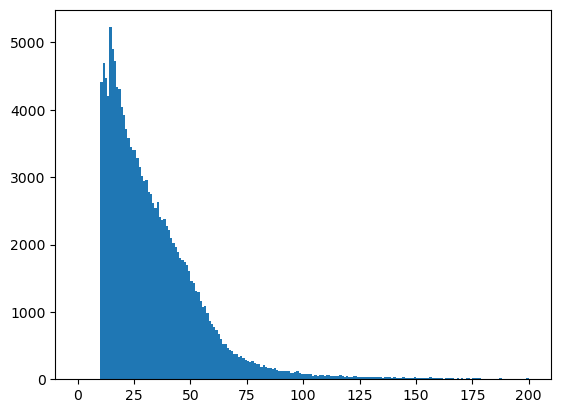

In [11]:
plt.hist(ak.flatten(photons.pt), bins = 200, range = (0, 200));

In [13]:
%jsroot on
pt_values = ak.flatten(photons.pt)

# Create a histogram: 200 bins between 0 and 200
hist = ROOT.TH1F("h_photon_pt", "Photon p_{T};p_{T} [GeV];Events", 200, 0, 200)

# Fill histogram
for pt in pt_values:
    hist.Fill(pt)

# Draw histogram
canvas = ROOT.TCanvas("c1", "Photon pT", 800, 600)
hist.SetLineColor(ROOT.kBlue)
hist.Draw("HIST")
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_photon_pt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [14]:
gen = events.GenPart

In [53]:
gen_photon = gen[(gen.pdgId == 22)]
mother_idx = gen_photon.genPartIdxMother
from_a_mask = gen[mother_idx].pdgId == 35
photons_from_a = gen_photon[from_a_mask]
photons_from_a = photons_from_a[ak.argsort(photons_from_a.pt, axis=1, ascending=False)]

In [55]:
lead_gen_pho_pt = ak.firsts(photons_from_a.pt)

In [56]:
sublead_gen_pho_pt = photons_from_a[:,1].pt

In [59]:
# Convert Awkward → NumPy for histogram filling
lead_np = ak.to_numpy(lead_gen_pho_pt)
sublead_np = ak.to_numpy(sublead_gen_pho_pt)

# Create histograms
h_lead = ROOT.TH1F("h_lead", "Leading and Subleading p_{T};p_{T} [GeV];Events", 50, 0, 200)
h_sublead = ROOT.TH1F("h_sublead", "Subleading p_{T}", 50, 0, 200)

# Fill histograms
for val in lead_np:
    h_lead.Fill(val)
for val in sublead_np:
    h_sublead.Fill(val)

# Style histograms
h_lead.SetLineColor(ROOT.kRed)
h_lead.SetLineWidth(2)
h_sublead.SetLineColor(ROOT.kBlue)
h_sublead.SetLineWidth(2)

# Normalize for comparison
if h_lead.Integral() > 0:
    h_lead.Scale(1.0 / h_lead.Integral())
if h_sublead.Integral() > 0:
    h_sublead.Scale(1.0 / h_sublead.Integral())

# Draw overlay
c = ROOT.TCanvas("c", "Overlay pT", 800, 600)
h_sublead.Draw("HIST")
h_lead.Draw("HIST SAME")


# Add legend
legend = ROOT.TLegend(0.65, 0.75, 0.88, 0.88)
legend.AddEntry(h_lead, "Leading p_{T}", "l")
legend.AddEntry(h_sublead, "Subleading p_{T}", "l")
legend.Draw()

# Optional CMS-like label
latex = ROOT.TLatex()
latex.SetNDC()
latex.SetTextSize(0.04)
latex.DrawLatex(0.15, 0.93, "#bf{CMS} Simulation")
latex.DrawLatex(0.65, 0.93, "13.6 TeV")

c.Update()
c.SaveAs("lead_sublead_pt_overlay.png")


Warning in <TROOT::Append>: Replacing existing TH1: h_lead (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_sublead (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file lead_sublead_pt_overlay.png has been created


In [39]:
photons_from_a.pt

<Array [[15.6, 21.7], [...], ..., [247, 87.5]] type='91256 * var * float32[...'>

In [26]:
events_20.Photon.pt

<Array [[53.3], [27.9, 13.5], ..., [], [46.9]] type='97537 * var * float32[...'>